###  Luis Ricardo Cruz García
#### Procesamiento de Lenguaje Natural

#### Tarea 3

In [1]:
import math
import nltk
import numpy as np
from nltk import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    f1_score, 
    precision_recall_fscore_support, 
    roc_auc_score)
import matplotlib
import matplotlib.pyplot as plt
from random import choices
from numpy.linalg import norm
from numpy import dot
from wordcloud import WordCloud # pip install wordcloud
from typing import Optional

In [2]:
def get_texts_from_file(path_corpus: str, path_label: str) -> tuple[list, list]:
    """Given the corpus and label paths, returns the list of docs and labels."""
    docs, labels = [], []

    with open(path_corpus, "r") as f_corpus:
        for doc in f_corpus:
            docs.append(doc)

    with open(path_label, "r") as f_labels:
        for label in f_labels:
            labels.append(label)

    return docs, labels

In [3]:
class Vocabulary:
    """Vocabulary class to store the ranking of the words in the given corpus."""
    def __init__(self, corpus_words: list[str], n_words : Optional[int] = None):
        corpus_freqdist = nltk.FreqDist(corpus_words)  # frequency distribution
        
        # the n_words most occurring words
        vocabulary_word_freq = self._sort_FreqDist(corpus_freqdist)
        
        if n_words is not None:
            vocabulary_word_freq = vocabulary_word_freq[:n_words]

        self.vocabulary = [word for word, freq in vocabulary_word_freq]
        
        # dictionary of the rank (frequency) of words in the vocabulary, word: freq_ranking
        self.word_to_index = {word: rank for rank, word in enumerate(self.vocabulary)}

    @staticmethod	
    def _sort_FreqDist(freqdist_obj: nltk.probability.FreqDist) -> list:
        """Return the list of items sorted by frequency (desc)."""
        aux = list(freqdist_obj.items())
        aux.sort(key=lambda x: x[1], reverse=True)
        return aux

    def __len__(self):
        return len(self.vocabulary)
    
    def __getitem__(self, key: str | int) -> int | str | None:
        """Depending of the type of the key, returns the word at 
        index key (if key is an integer) or the rank of the 
        word key (if key is a string).
        """
        if not isinstance(key, int) and not isinstance(key, np.int64) and not isinstance(key, str):
            raise ValueError("key must be an integer or a string")
        
        if isinstance(key, int) or isinstance(key, np.int64):
            return self.vocabulary[key]

        if isinstance(key, str):
            return self.word_to_index[key]

    def __contains__(self, key: str) -> bool:
        return key in self.word_to_index


In [4]:
tokenizer = TweetTokenizer()

In [5]:
# get training docs and labels
train_docs, train_labels = get_texts_from_file("../../Data/mex_train.txt", "../../Data/mex_train_labels.txt")
train_labels = list(map(int, train_labels))  # cast to integer

In [6]:
corpus_words = []
for doc in train_docs:
    corpus_words += tokenizer.tokenize(doc.lower())

# remove stopwords
set_stopwords = set(stopwords.words("spanish"))
corpus_words = [w for w in corpus_words if w not in set_stopwords]

vocabulary = Vocabulary(corpus_words, n_words=None)

## 1.2 Selección de términos y DTR's

### 1. Programa y visualiza TCOR. Puede hacer esto de forma similar a como el profesor lo hizo en la Práctica 4 con DOR. El pesado puede ser el que el profesor sugirió en clase o PPMI como lo sugiere Dan Jurafsky; hacer al menos dos gráficas, la de constelación de palabras y subconjunto para ver algunas palabras con flechas.

$TCOR = (w_{k,j})$, where
$$w_{k,j} = \operatorname{tff}(t_k, t_j) \times \log \left( \frac{|T|}{T_k} \right)$$
where
- $\operatorname{tff}(t_k, t_j) = \begin{cases} 1 + \log(\#(t_k, t_j)) & \text{if } \#(t_k, t_j) \neq 0 \\ 0 & \text{otherwise} \end{cases}$, 

where $\#(t_k, t_j) =$ number of documents s.t. $t_k$ and $t_j$ co-occur.
- $T =$ vocabulary
- $T_k =$ number of terms wich co-occur with term $t_k$ in at least one document.

In [7]:
def build_TCOR(docs: list[str], 
               vocabulary: Vocabulary, 
               n_terms: int) -> np.ndarray:
    """Builds the TCOR (Term Co-Occurrence Representation) representation of the words (terms) in the given vocabulary.
    
    NOTE: In this function, a document is the context for wich co-occurrence happens, i.e., 
    the words "w1" and "w2" co-occur if there exists a document "d" such that "w1" and "w2" 
    are words tha occur in that document ("w1" in "d" and "w2" in "d").
    """
    
    TCOR = np.zeros((n_terms, n_terms), dtype=np.float64)

    # set of words in the vocabulary (with rank < n_terms) for every document
    tokenized_docs = []
    for doc in docs:
        tokenized_docs.append(set(word for word in tokenizer.tokenize(doc) if word in vocabulary and vocabulary[word] < n_terms))

    # T_k -> num words (terms) that co-occurred with t_k at least once in a doc.
    T_k = np.zeros(n_terms)
    for k, t_k in enumerate(vocabulary.vocabulary[:n_terms]):
        words_tk_co_occurred_with = set()
        for doc_words in tokenized_docs:
            # if t_k is a term in the current doc, every term in the doc co-occurs with t_k.
            if t_k in doc_words:
                words_tk_co_occurred_with.update(doc_words)

        T_k[k] = len(words_tk_co_occurred_with)

    # N_tkj[k][j] -> number of docs such that t_k and t_j co-occur.
    Nt_kj = np.zeros((n_terms, n_terms))

    # since every doc has very few words, there aren't many pairs of words, so it's faster this way.
    for doc_words in tokenized_docs:
        for w1 in doc_words:
            for w2 in doc_words:
                Nt_kj[vocabulary[w1], vocabulary[w2]] += 1

    # compute the formula directly
    for k in range(n_terms):
        for j in range(n_terms):
            if Nt_kj[k][j] > 0:
                TCOR[k, j] = (1 + math.log10(Nt_kj[k][j])) * math.log10(n_terms / T_k[k])

    return TCOR

In [8]:
def build_BoW_freq(docs: list[str], 
                   vocabulary: Vocabulary, 
                   n_terms: int | None) -> np.ndarray:
    if n_terms is None:
        n_terms = len(vocabulary)
    
    BoW = np.zeros((len(docs), n_terms), dtype=float)

    for i, doc in enumerate(docs):
        fdist_docs = nltk.FreqDist(tokenizer.tokenize(doc))
        for w in vocabulary.vocabulary:
            if vocabulary[w] < n_terms:
                BoW[i, vocabulary[w]] = fdist_docs[w]

    return BoW

In [9]:
TCOR_train = build_TCOR(train_docs, vocabulary, n_terms=5000)
TCOR_train = normalize(TCOR_train)

In [10]:
train_BoW_freq = build_BoW_freq(train_docs, vocabulary, n_terms=5000)

# select the 1000 best features (terms) using chi squared ranking function
top_1k_best_terms = SelectKBest(chi2, k=1000)
top_1k_best_terms.fit(train_BoW_freq, train_labels)

# indices of the 1k best terms.
best_words_indices = top_1k_best_terms.get_support(indices=True)

In [11]:
# list of the 1k best features
best_1k_words = [vocabulary[index] for index in best_words_indices]

In [12]:
# filter the TCOR matrix with the 1k best words
TCOR_train_1k = np.take(TCOR_train, best_words_indices, axis=0)

In [53]:
reduced_TCOR_matrix = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(TCOR_train_1k)

/home/lrcg/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


/home/lrcg/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lrcg/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lrcg/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lrcg/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lrcg/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129316 (\N{DROOLING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw

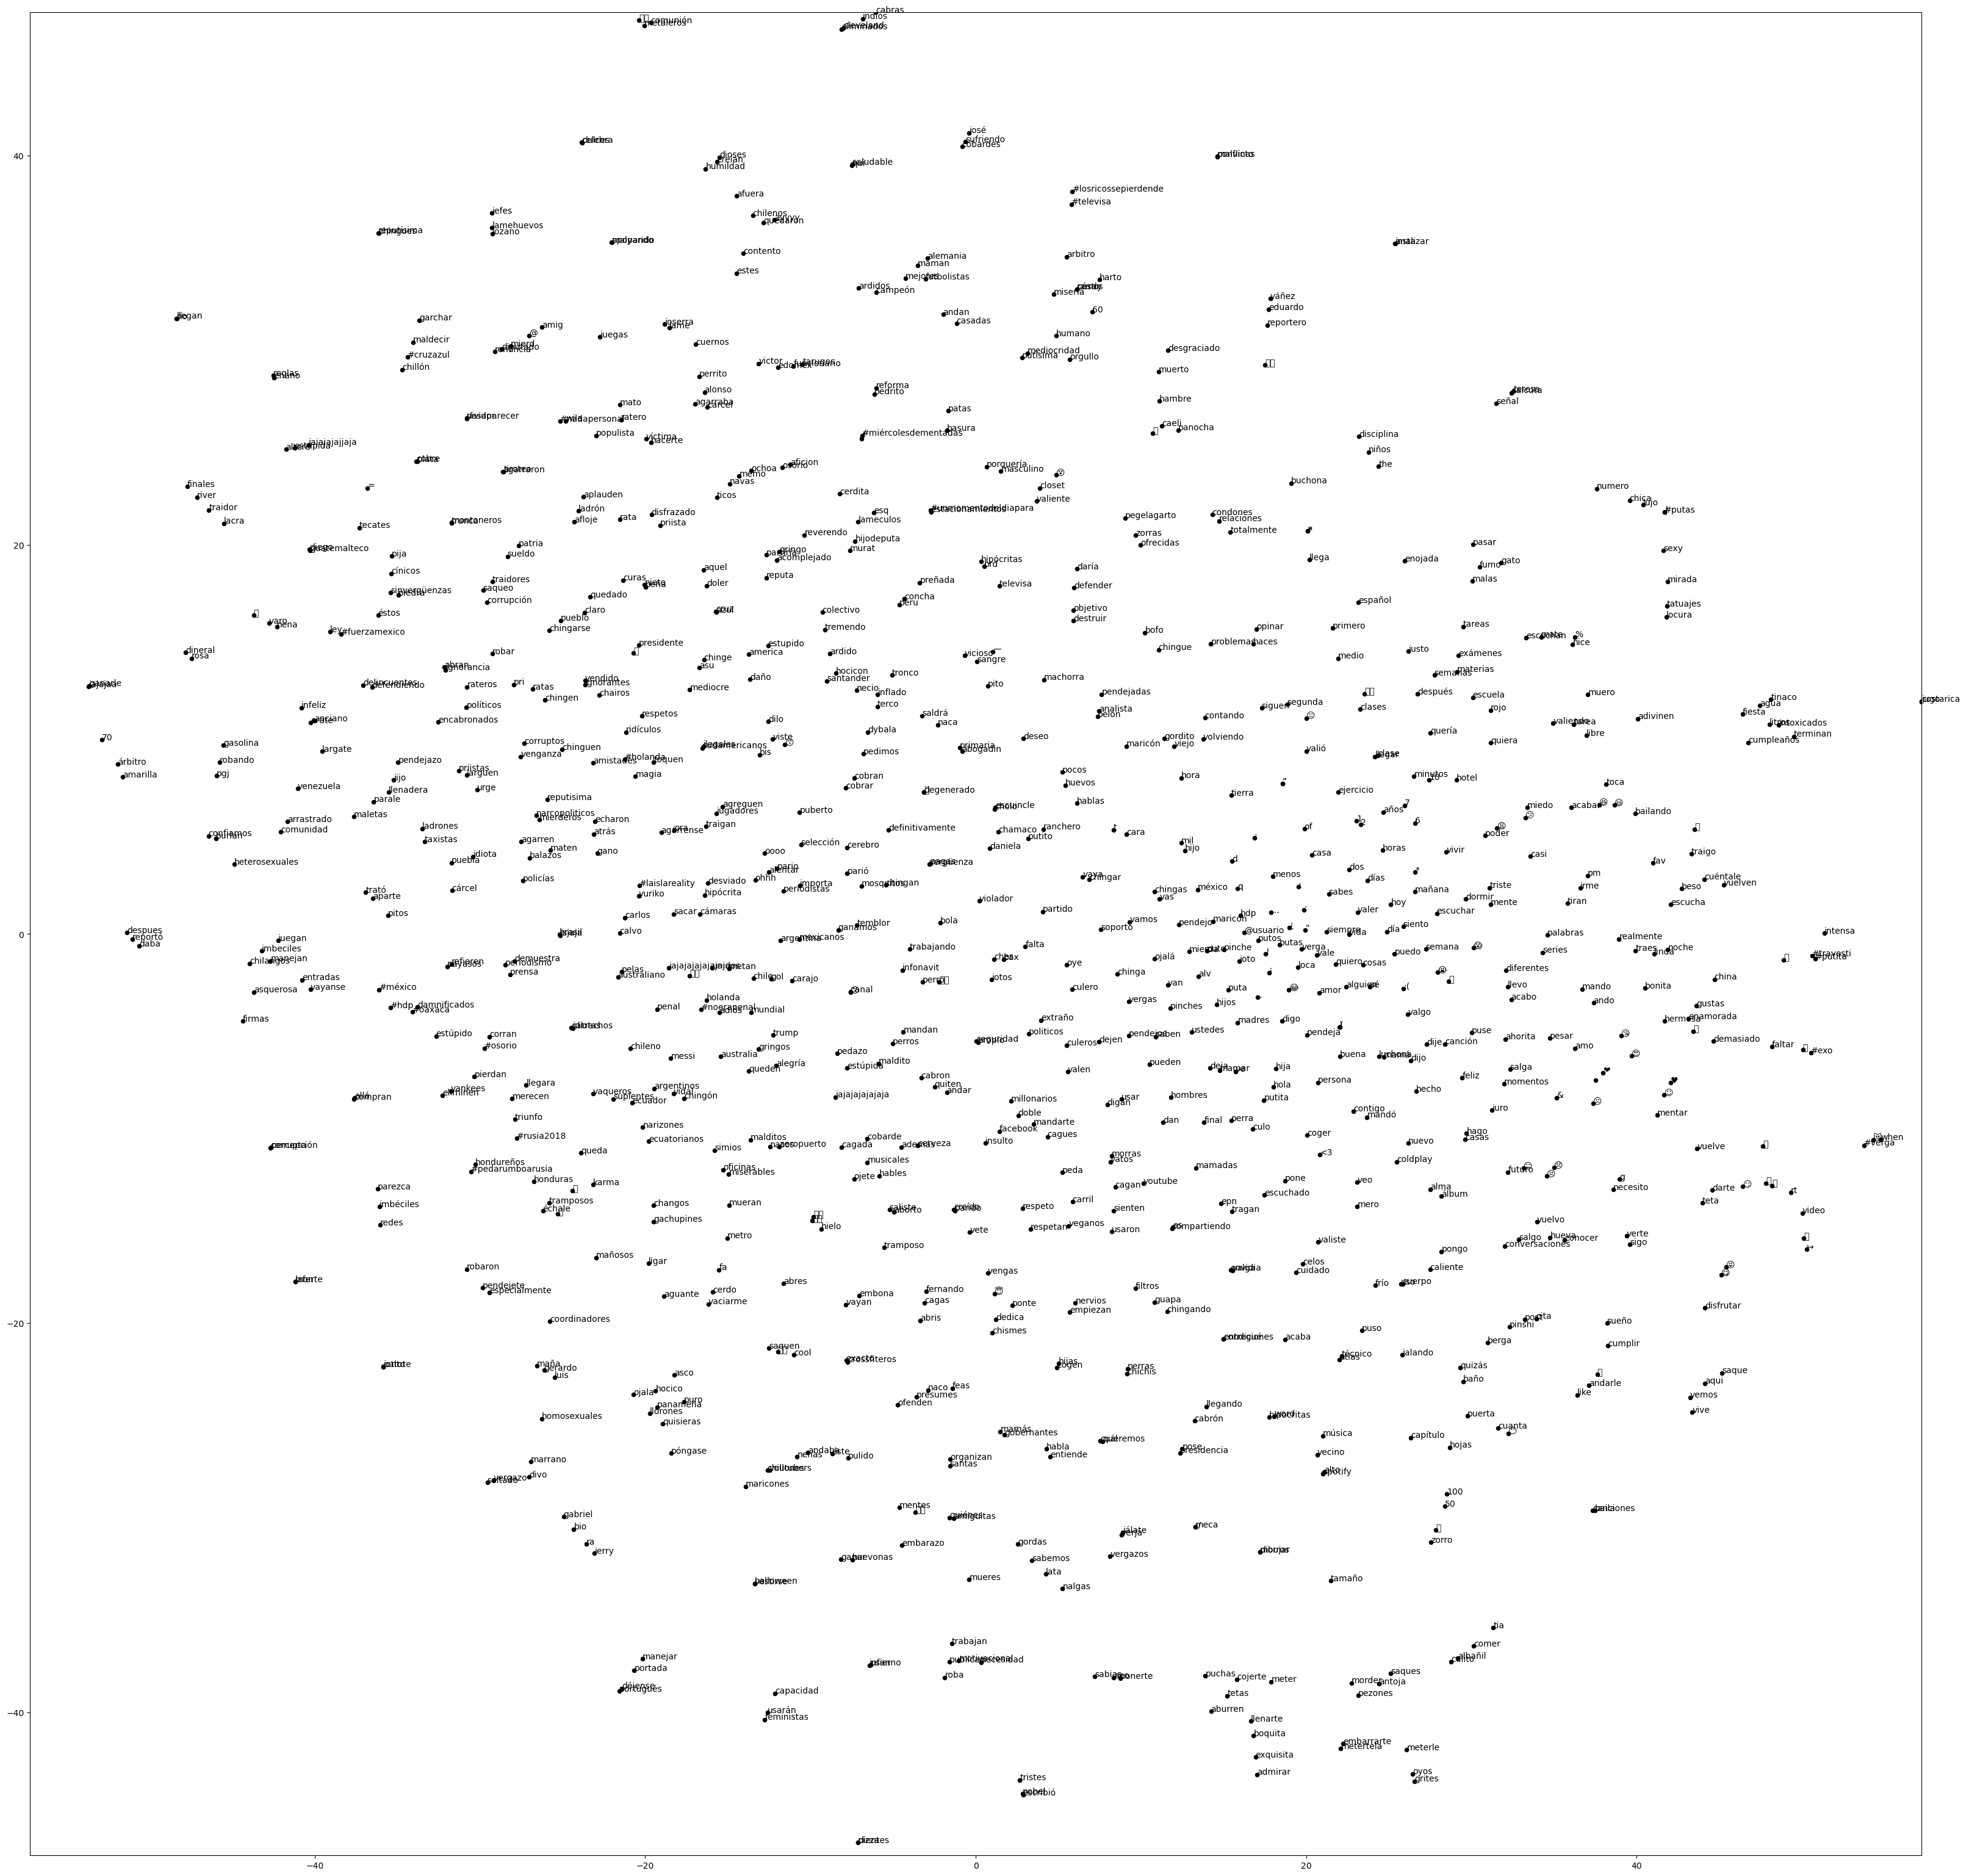

In [54]:
max_x = np.amax(reduced_TCOR_matrix, axis=0)[0]
max_y = np.amax(reduced_TCOR_matrix, axis=0)[1]

matplotlib.rc('font', family='DejaVu Sans')

plt.figure(figsize=(40,40), dpi=100)
plt.xlim((-max_x, max_x))
plt.ylim((-max_y, max_y))

plt.scatter(reduced_TCOR_matrix[:, 0], reduced_TCOR_matrix[:, 1], 20, color="black")

# graph the labels for each word
for i, word in enumerate(best_1k_words):
    x = reduced_TCOR_matrix[i, 0]
    y = reduced_TCOR_matrix[i, 1]
    plt.annotate(word, (x, y), color="black")

In [55]:
test_words = ["gol", "partido", "árbitro", "gol", "america", "agua", "litros", "tinaco", "chile", "holanda", "argentina", "australia", "chileno", "hondureños", "alemania", "peru", "ecuador"]
test_words_indices = [best_1k_words.index(word) for word in test_words]

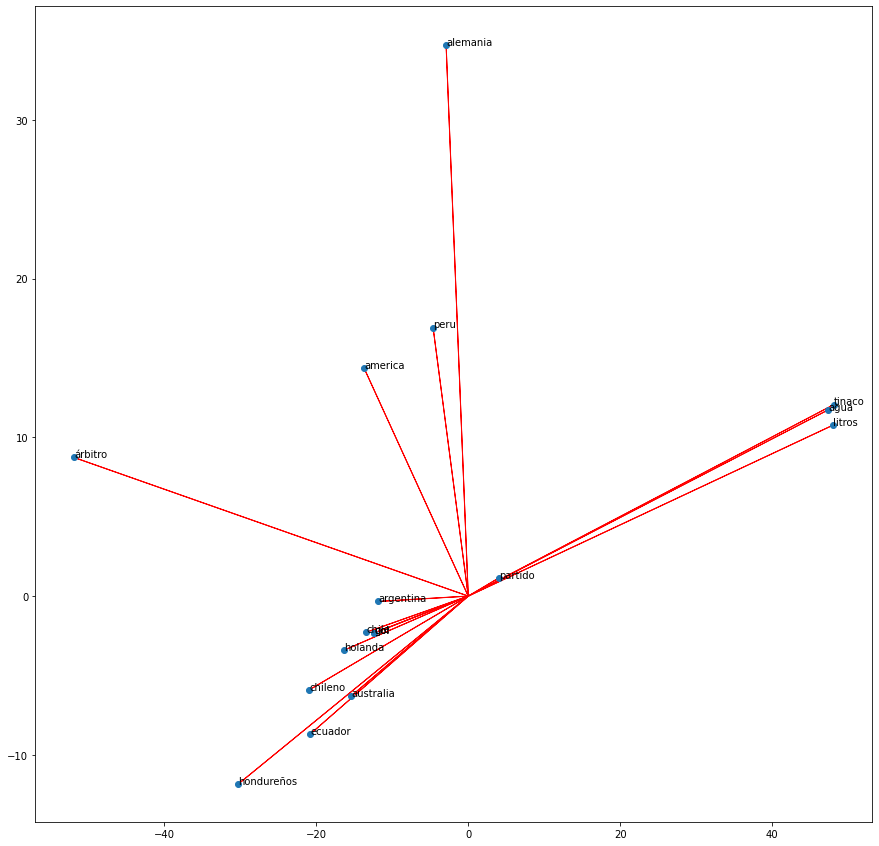

In [56]:
# select the rows (vectors) corresponding to the test_words
reduced_TCOR_test_words = np.take(reduced_TCOR_matrix, test_words_indices, axis=0)

fig, ax = plt.subplots(figsize=(15, 15))

for x, y in reduced_TCOR_test_words:
    ax.arrow(0, 0, x, y, head_width=0.08, head_length=0.08, fc="r", ec="r", width=1e-2)

ax.scatter(reduced_TCOR_test_words[:, 0], reduced_TCOR_test_words[:, 1])

for i, word in enumerate(test_words):
    ax.annotate(word, (reduced_TCOR_test_words[i, 0], reduced_TCOR_test_words[i, 1]))

### 2. Programa y visualiza alguna implementación de Random Indexing. Puedes hacer esto de forma similar a como el profesor lo hizo en la Práctica 4 con DOR. Hacer al menos dos gráficas, la de constelación de palabras y subconjunto para ver algunas palabras con flechas.

In [18]:
def build_RandIndexing(train_docs: list[str], 
                       vocabulary: Vocabulary, 
                       n_terms: int, 
                       d: int, 
                       n_ones: int) -> np.ndarray:
    """
    Builds a random indexing representation of the (n_terms) words in the vocabulary using the train docs.
    
    Based on the article "An Introduction to Random Indexing" by Magnus Sahlgren.
    
    n_terms: number of terms to be represented.
    d: index vectors dimensions.
    n_ones: number of 1's (and -1's) to be initialy in the index vectors. 
    """
    matrix = np.zeros((n_terms, d))

    index_vectors = np.zeros((len(train_docs), d))
    for i in range(n_terms):
        # choose the indices for 1's and -1's
        ones_indices = choices(range(d), k=n_ones)
        minus_one_indeces = choices(range(d), k=n_ones)
        for j in ones_indices:
            index_vectors[i][j] = 1

        for j in minus_one_indeces:
            index_vectors[i][j] = -1


    for i, doc in enumerate(train_docs):
        fdist_tweet = nltk.FreqDist(tokenizer.tokenize(doc))
        for w in fdist_tweet:
            if w in vocabulary and vocabulary[w] < n_terms:
                matrix[vocabulary[w]] += index_vectors[i]

    return matrix

In [19]:
randindex_train = build_RandIndexing(train_docs, vocabulary, n_terms=5000, d=300, n_ones=40)
randindex_train = normalize(randindex_train, norm="l2")

In [20]:
# filter the randindex matrix with the 1k best words
randindex_train_1k = np.take(randindex_train, best_words_indices, axis=0)

In [59]:
reduced_randindex_matrix = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(randindex_train_1k)

/home/lrcg/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


/home/lrcg/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128405 (\N{REVERSED HAND WITH MIDDLE FINGER EXTENDED}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lrcg/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127814 (\N{AUBERGINE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lrcg/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128148 (\N{BROKEN HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lrcg/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128166 (\N{SPLASHING SWEAT SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lrcg/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129316 (\N{DROOLING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw

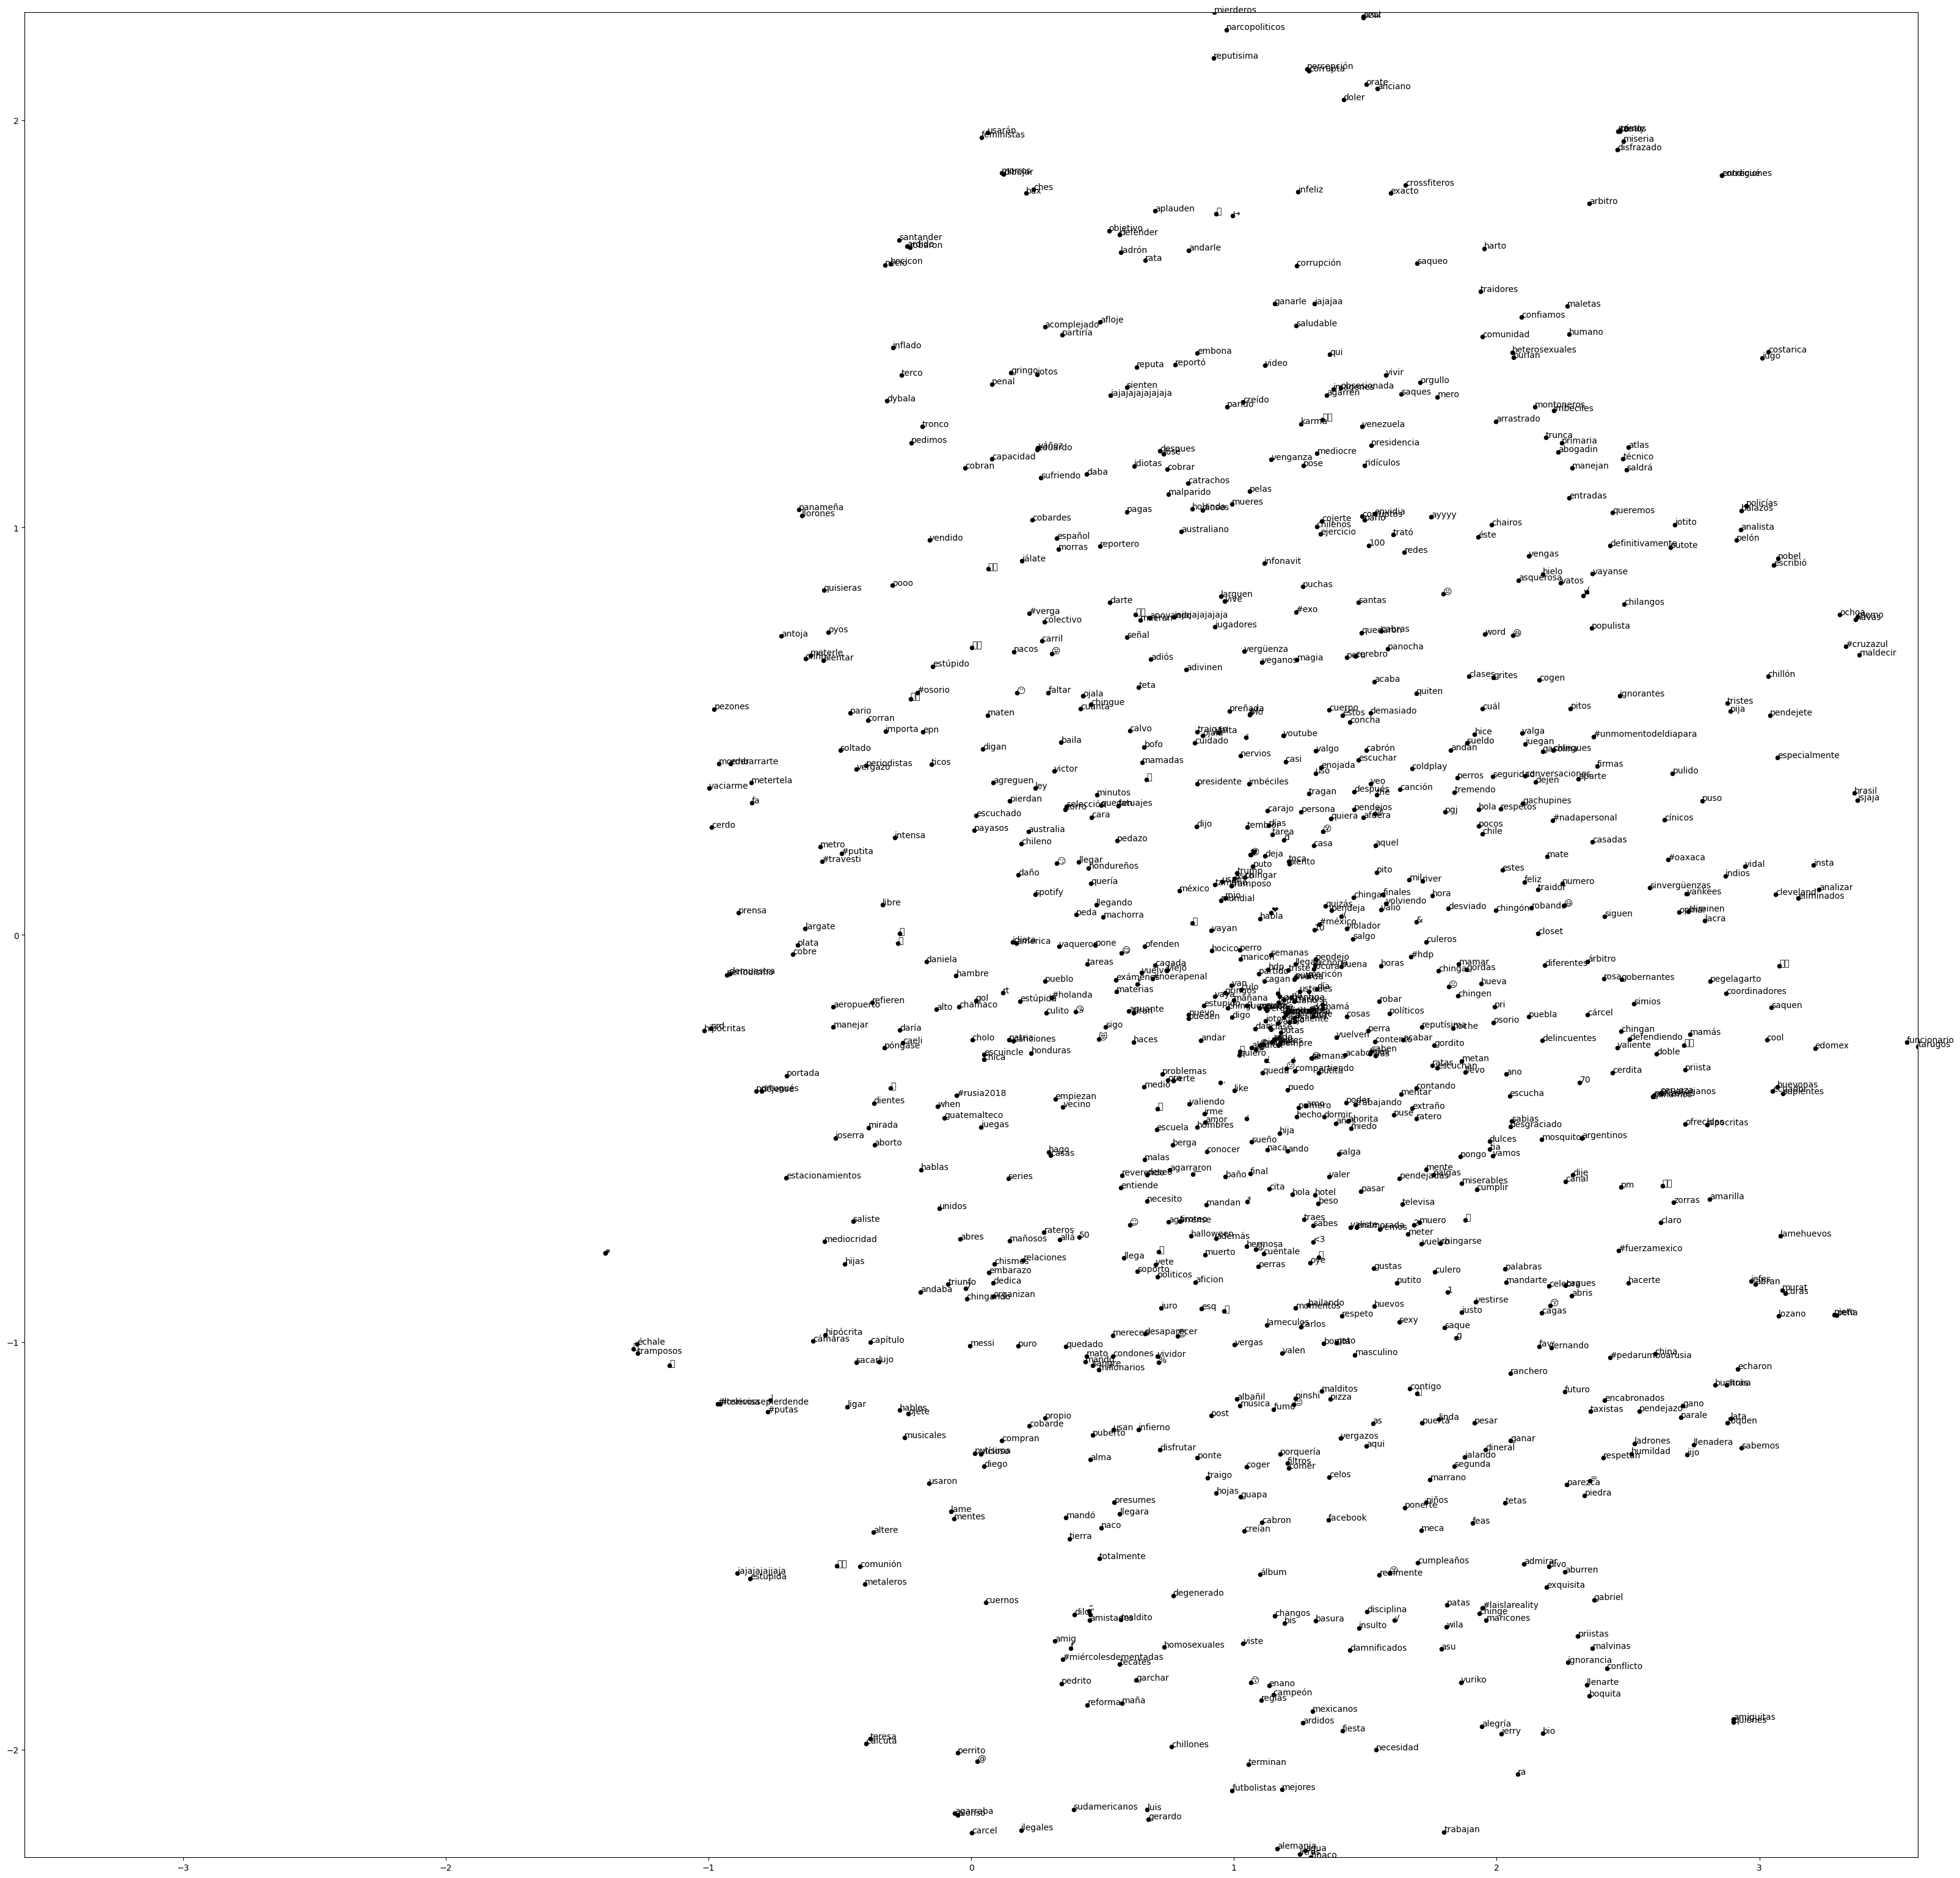

In [60]:
max_x = np.amax(reduced_randindex_matrix, axis=0)[0]
max_y = np.amax(reduced_randindex_matrix, axis=0)[1]

matplotlib.rc('font', family='DejaVu Sans')

plt.figure(figsize=(40,40), dpi=100)
plt.xlim((-max_x, max_x))
plt.ylim((-max_y, max_y))

plt.scatter(reduced_randindex_matrix[:, 0], reduced_randindex_matrix[:, 1], 20, color="black")

# graph word labels
for idx, word in enumerate(best_1k_words):
    x = reduced_randindex_matrix[idx, 0]
    y = reduced_randindex_matrix[idx, 1]
    plt.annotate(word, (x, y), color="black")

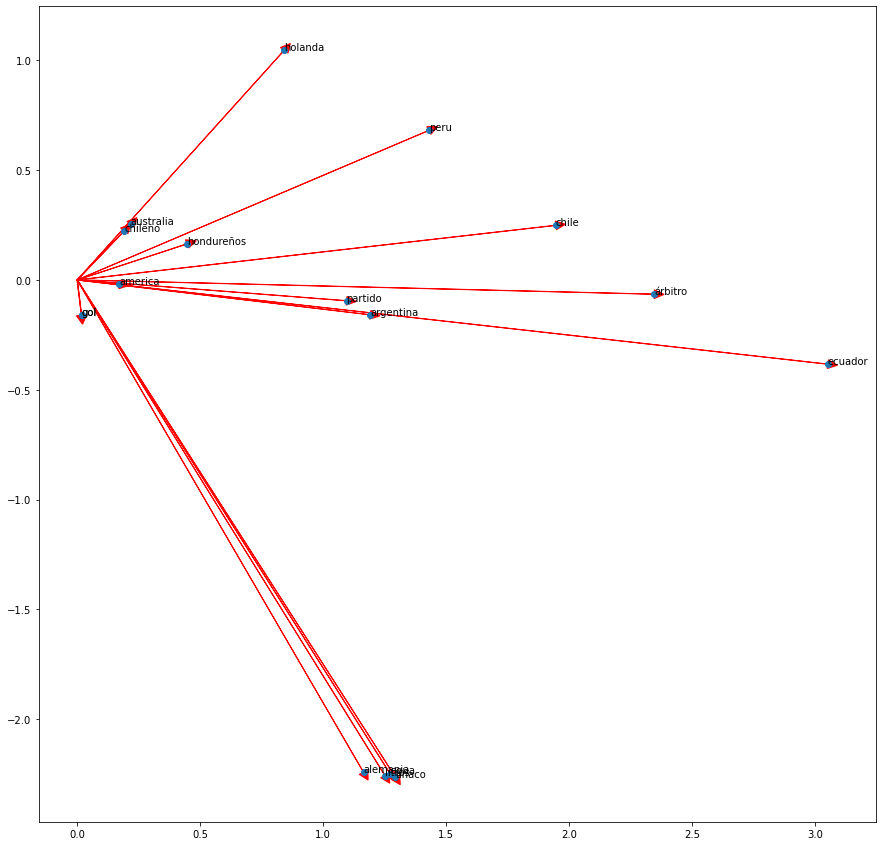

In [61]:
# select the rows (vectors) corresponding to the test_words
reduced_randindex_test_words = np.take(reduced_randindex_matrix, test_words_indices, axis=0)

fig, ax = plt.subplots(figsize=(15, 15))

for x, y in reduced_randindex_test_words:
    ax.arrow(0, 0, x, y, head_width=0.04, head_length=0.04, fc="r", ec="r", width=1e-3)

ax.scatter(reduced_randindex_test_words[:, 0], reduced_randindex_test_words[:, 1])

for i, word in enumerate(test_words):
    ax.annotate(word, (reduced_randindex_test_words[i, 0], reduced_randindex_test_words[i, 1]))

### 3. Use alguna de las DTRs anteriores por separado de alguna forma para clasificación de documentos (e.g., promedio de vectores de términos en cada documento para representar). Compárelas contra un BoW-TFIDF de 5000 palabras más frecuentes.

In [24]:
# GridSearchCV parameters
parameters = {'C' : [0.05, 0.12, 0.25, 0.5, 1, 2, 4]}

In [25]:
def prediction_svm_model(train_BoW, validation_BoW, train_labels, max_iter=2000):
    """Creates a linear SVM classification model and returns the prediction 
    of labels for the validation BoW.
    """
    svm_lin_class = svm.LinearSVC(class_weight="balanced", 
                                  max_iter=max_iter)
    
    grid = GridSearchCV(
                estimator=svm_lin_class, 
                param_grid=parameters, 
                n_jobs=8, 
                scoring="f1_macro", 
                cv=5)
    
    grid.fit(train_BoW, train_labels)
    
    y_prediction = grid.predict(validation_BoW)
    
    return y_prediction

In [26]:
def build_BoW_tfidf(docs: list[str], 
                    vocabulary: Vocabulary, 
                    n_terms: int) -> np.ndarray:
    N = len(docs)
    T = len(vocabulary)
    BoW = np.zeros((len(docs), n_terms), dtype=float)

    tokenized_docs = [tokenizer.tokenize(doc) for doc in docs]

    df = [0] * len(vocabulary)
    for i, w in enumerate(vocabulary.vocabulary[:n_terms]):
        df[i] = 1 + sum(1 for j in range(len(docs)) if w in tokenized_docs[j])

    for i, doc in enumerate(docs):
        word_freq = nltk.FreqDist(tokenized_docs[i])
        for j, w in enumerate(vocabulary.vocabulary[:n_terms]):
            BoW[i, vocabulary[w]] = float(word_freq[w]) * math.log(N / df[j])

    return BoW

In [27]:
# get validation docs and labels
val_docs, val_labels = get_texts_from_file("../../Data/mex_val.txt", "../../Data/mex_val_labels.txt")
val_labels = list(map(int, val_labels))

In [28]:
train_BoW_tfidf = build_BoW_tfidf(train_docs, vocabulary, n_terms=5000)
val_BoW_tfidf = build_BoW_tfidf(val_docs, vocabulary, n_terms=5000)

In [29]:
labels_pred_tfidf = prediction_svm_model(train_BoW_tfidf, val_BoW_tfidf, train_labels, max_iter=20000)

print(f"confusion matrix:\n{confusion_matrix(val_labels, labels_pred_tfidf)}")
print("-" * 70)
print(metrics.classification_report(val_labels, labels_pred_tfidf))

confusion matrix:
[[328  69]
 [ 75 144]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       397
           1       0.68      0.66      0.67       219

    accuracy                           0.77       616
   macro avg       0.74      0.74      0.74       616
weighted avg       0.76      0.77      0.77       616



/home/lrcg/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [30]:
TCOR_val = build_TCOR(train_docs, vocabulary, n_terms=5000)

In [31]:
def doc_representation_TCOR(docs: list[str], 
                            TCOR: np.ndarray, 
                            vocabulary: Vocabulary) -> np.ndarray:
    """Computes the docs representation using the TCOR term representation 
    of words in the given vocabulary.
    """
    n_terms = TCOR.shape[0]
    representation = np.zeros((len(docs), n_terms))

    for i, doc in enumerate(docs):
        word_freq = nltk.FreqDist(tokenizer.tokenize(doc))
        count = 0
        for w in word_freq:
            if w in vocabulary and vocabulary[w] < n_terms:
                representation[i] += TCOR[vocabulary[w]]
                count += 1

    return representation

In [39]:
TCOR_docs_train = doc_representation_TCOR(train_docs, TCOR_train, vocabulary)
TCOR_docs_train = normalize(TCOR_docs_train)

In [40]:
TCOR_docs_val = doc_representation_TCOR(val_docs, TCOR_train, vocabulary)
TCOR_docs_val = normalize(TCOR_docs_val)

In [41]:
labels_pred_TCOR = prediction_svm_model(TCOR_docs_train, TCOR_docs_val, train_labels, max_iter=20000)

print(f"confusion matrix:\n{confusion_matrix(val_labels, labels_pred_TCOR)}")
print("-" * 70)
print(metrics.classification_report(val_labels, labels_pred_TCOR))

confusion matrix:
[[312  85]
 [ 55 164]]
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       397
           1       0.66      0.75      0.70       219

    accuracy                           0.77       616
   macro avg       0.75      0.77      0.76       616
weighted avg       0.78      0.77      0.78       616



El accuracy en el caso de la representación del documento con TCOR es de $0.77$ y en el caso de la representación usando una bolsa de palabras con pesado TF-IDF fue también de $0.77$, por lo que, en este caso, ambas opciones son igual de buenas para clasificar.

### 4. Bajo la representación TCOR de los términos, y asumiendo un vocabulario de 5000 palabras, muestre por orden de mayor similitud coseno (ver chp. 6 del libro de Dan) los 10 pares de palabras más parecidas en toda la colección.

In [42]:
def cosine(v: np.ndarray, w: np.ndarray) -> float:
    """Cosine similarity between two 1-rank numpy arrays."""
    return dot(v, w) / (norm(v) * norm(w))

In [43]:
def top_k_cosine_similar(word_repr: np.ndarray, 
                         k: int, 
                         vocabulary: Vocabulary) -> None:
    """
    Prints the k most similar (cosine similarity) using the given word representation. 
    """
    ncols = word_repr.shape[0]
    cosine_index = []
    for i in range(ncols):
        for j in range(i):
                cosine_index.append([cosine(word_repr[i], word_repr[j]), i, j])

    cosine_index.sort(key=lambda x : x[0], reverse=True)

    top_k = cosine_index[:k]

    top_k_words = [(vocabulary[i], vocabulary[j]) for cos_v, i, j in top_k]

    print(top_k_words)

In [44]:
top_k_cosine_similar(TCOR_train, k=10, vocabulary=vocabulary)

[('daddy', 'sugar'), ('autostop', 'axe'), ('picada', 'axe'), ('picada', 'autostop'), ('lanzar', 'axe'), ('lanzar', 'autostop'), ('lanzar', 'picada'), ('fragancia', 'axe'), ('fragancia', 'autostop'), ('fragancia', 'picada')]


### 5. Bajo la representación BoW-TFIDF de los documentos, y asumiendo un vocabulario de 5000 palabras, muestre en por orden de más similitud coseno (ver chp 6 del libro de Dan) los 10 pares de documentos más parecidos en toda la colección. Muestre el texto que contienen y muestre la categoría de cada uno.

In [47]:
def top_k_cosine_similar_docs(Docs, Representation, k):
    nrows = Representation.shape[0]

    cosine_index = []
    for i in range(nrows):
        for j in range(i):
            cosine_index.append([cosine(Representation[i], Representation[j]), i, j])

    cosine_index.sort(key=lambda x : x[0], reverse=True)

    top_k = cosine_index[:k]

    for cos_v, i , j in top_k:
        print(Docs[i])
        print(Docs[j])
        print("cos = ", cos_v)
        print("-" * 70)

In [48]:
top_k_cosine_similar_docs(train_docs, train_BoW_tfidf, k=10)

@usuario mamá luchona y garrafona

@usuario es una mamá luchona

cos =  1.0
----------------------------------------------------------------------
@usuario mamá luchona activated mode 🤖

@usuario es una mamá luchona

cos =  1.0
----------------------------------------------------------------------
@usuario mamá luchona activated mode 🤖

@usuario mamá luchona y garrafona

cos =  1.0
----------------------------------------------------------------------
#nadapersonal chinga tu madre

#nadapersonal pero chinga tu madre

cos =  1.0
----------------------------------------------------------------------
una flaquita tetona recibe su dotación mientras chupa otra verga! ¡mira su cara de placer!  rt para más vídeos

una flaquita tetona recibe su dotación mientras chupa otra verga! ¡mira su cara de placer! rt para más vídeos

cos =  1.0
----------------------------------------------------------------------
yo fui de los que le menté su madre a @usuario pero ya lo perdoné.

@usuario inténtalo est

### 6. Implemente Ganancia de Información o Chi2 como lo sugiere Baeza-Yates (no función de sklearn ni similar) para descubrir el top 50 de las palabras más relevantes de TODA la colección.

In [49]:
def top_50_feature_selection_chi2(docs, labels, vocabulary):
    def X2_k_i_c_p(index, class_index): 
        n_class = n_agresivo if class_index == 0 else n_no_agresivo
        return (N_t * (N_t * n_ip[index][class_index] - n_class * n_i[index])) / (n_class * n_i[index] * (N_t - n_class) * (N_t - n_i[index]) )

    n_agresivo = sum(labels)
    n_no_agresivo = len(labels) - n_agresivo

    N_t = len(vocabulary)

    print("tokenizing ...")

    tokenized_docs = [set(tokenizer.tokenize(doc)) for doc in docs]

    print("tokenized!")

    print("computing n_i, n_ip ...")

    n_i = [0] * (len(vocabulary))
    for i in range(len(vocabulary)):
        n_i[i] = sum([1 for doc_words in tokenized_docs if vocabulary[i] in doc_words])


    # n_ip = |\{ d \in D_t : d \in C_p \land k_i \in d \}1 
    n_ip = [[0, 0] for _ in range(len(vocabulary))]

    for i in range(len(vocabulary)):
        for p in [0, 1]:
            for k, doc_words in enumerate(tokenized_docs):
                if vocabulary[i] in doc_words and labels[k] == p:
                    n_ip[i][p] += 1

    print("n_i, n_ip computed!")

    # top k words
    chi2_words = [[0, 0] for _ in range(len(vocabulary))]

    for i in range(len(vocabulary)):
        chi2_words[i][0] = max(X2_k_i_c_p(i, 0), X2_k_i_c_p(i, 1))
        chi2_words[i][1] = i

    chi2_words.sort(key=lambda x : x[0], reverse=True)

    return [vocabulary[chi2_words[i][1]] for i in range(50)]

In [50]:
top_50_words = top_50_feature_selection_chi2(train_docs, train_labels, vocabulary)

tokenizing ...
tokenized!
computing n_i, n_ip ...
n_i, n_ip computed!


In [51]:
top_50_words

['loca',
 'escuela',
 'quiera',
 'valgo',
 '😔',
 'teresa',
 'traigo',
 'calcuta',
 'aqui',
 'chica',
 'salgo',
 'mandó',
 'toca',
 'semanas',
 'baño',
 'hermosa',
 'tristes',
 'valiste',
 'acabar',
 '🤤',
 '💖',
 'hotel',
 'nervios',
 'puerta',
 'vuelven',
 'tareas',
 'alto',
 'alma',
 'gustas',
 'salga',
 'demasiado',
 'vuelvo',
 '💜',
 'celos',
 'linda',
 '😞',
 'gato',
 'vive',
 'mosquitos',
 'cuerpo',
 'enamorada',
 '☺',
 'tinaco',
 'español',
 '#travesti',
 '#verga',
 'tatuajes',
 'conocer',
 'when',
 'uso']

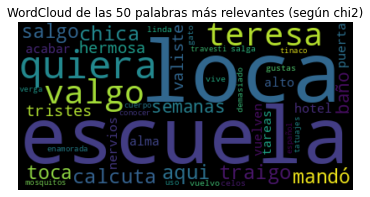

In [52]:
wordcloud = WordCloud().generate(' '.join(top_50_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud de las 50 palabras más relevantes (según chi2)")
plt.show()